# 🧮 **Quantum LDE Solver for Simple Harmonic Motion**

Following
>Xin, T., Wei, S., Cui, J., Xiao, J., Arrazola, I., Lamata, L., Kong, X.-Y., Lu, D., Solano, E., & Long, G.-L. (2020). Quantum algorithm for solving linear differential equations: Theory and experiment. Physical Review A, 101(3). https://doi.org/10.1103/physreva.101.032307

⚜️ **Name:** Sibishan Ravindran <br>
⚜️ **University:** University of Technology Sydney <br>
⚜️ **Subject:** 41173 - Quantum Software and Programming <br>

## 🚧 **Development Environment Setup**

🛠️ **Development Environment:** Classiq Studio (_classiq-venv(Python 3.12.11)_)

These imports set up numerical utilities, typing for clearer function signatures, and the Classiq Qmod SDK for building and synthesising quantum programs used in this notebook.

In [1]:
import math											# Standard library for mathematical operations
import numpy as np									# Third-party library for numerical arrays
from typing import Tuple, Dict, Any, Union			# Type hints for function signatures
from classiq import *								# Qmod SDK for quantum programming

## ⏳ **Preprocessing**

### `form_lde`

**Purpose**  
Create the linear state space model for a simple harmonic oscillator so it fits the solver form `dX/dt = M X + b`.

**Steps**  
1. Form the system matrix `M = [[0, 1], [−ω^2, 0]]`.  
2. Set initial state `x0 = [1, 1]` for position and velocity.  
3. Set forcing `b = [0, 0]`.  
4. Return `(M, x0, b)`.

>$$
\dot{\mathbf X}(t) = M\,\mathbf X(t) + \mathbf b,\quad
\mathbf X(t)=\begin{bmatrix}x\\ \dot x\end{bmatrix},\quad
M=\begin{bmatrix}0 & 1\\ -\omega^2 & 0\end{bmatrix},\quad
\mathbf b=\begin{bmatrix}0\\ 0\end{bmatrix}.
$$



In [2]:
def form_lde(omega: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
	# System matrix for the Simple Harmonic Oscillator in first order form
    # State X = [x, x_dot], with dynamics:
    #   d/dt  [x    ] = [ 0,       1 ] [x    ] + [0]
    #         [x_dot]   [−omega^2, 0 ] [x_dot]   [0]
    M = np.array([[0, 1], [-omega**2, 0]], dtype=float)

    # Initial condition, position = 1, velocity = 1
    x0 = np.array([1, 1], dtype=float)

    # No constant forcing term
    b = np.array([0, 0], dtype=float)

    return M, x0, b

### `calculate_operator_norm`

**Purpose**  
Compute the matrix 2 norm, also called the spectral norm, which equals the largest singular value of the matrix.

**Steps**  
1. Call `np.linalg.norm(M, ord=2)` to get the spectral norm.  
2. Return the result as a float.

>$$
\|M\|_{2} \,=\, \sigma_{\max}(M),
$$
>where $\sigma_{\max}(M)$ is the largest singular value of $M$.

In [3]:
def calculate_operator_norm(M: np.ndarray) -> float:
    return np.linalg.norm(M, ord=2) # Return the matrix spectral norm

### `normalise_matrix`

**Purpose**  
Scale a matrix by its 2 norm so the result has unit 2 norm, and return both the scaled matrix and the original norm.

**Steps**  
1. Compute $\|M\|_{2}$ using `calculate_operator_norm`.  
2. Form $A = M / \|M\|_{2}$.  
3. Return $A$ and $\|M\|_{2}$.
  
>$$
A = \frac{M}{\|M\|_{2}}, \quad \|A\|_{2} = 1 \text{ if } \|M\|_{2} \neq 0.
$$

In [4]:
def normalise_matrix(M: np.ndarray) -> Tuple[np.ndarray, float]:
    M_norm = calculate_operator_norm(M)		# spectral norm ‖M‖_2

    # Guards, assert will fail fast in debug, ValueError is safer in production
    assert np.isfinite(M_norm), "Spectral norm is not finite"
    tol = 1e-12  # numerical tolerance
    assert M_norm > tol, "‖M‖_2 is zero or numerically zero, cannot normalise the zero matrix"

    A = M / M_norm							# Normalise M by its norm
    return A, float(M_norm)					# Return the scaled matrix and the scaling factor

### `verify_unitary`

**Purpose**  
Determine if a matrix is unitary within a given absolute tolerance.

**Steps**  
1. Compute the product $A A^\dagger$.  
2. Form the identity matrix $I$ of matching size.  
3. Use `np.allclose` with `atol=tolerance` to compare $A A^\dagger$ and $I$.  
4. Return `True` if they are close, otherwise `False`.

>$$
A A^\dagger = I_N \quad \text{for a unitary matrix},
$$
>$$
\lVert A A^\dagger - I_N \rVert_\infty \le \text{tolerance}.
$$


In [5]:
def verify_unitary(A: np.ndarray, tolerance: float = 1e-10) -> bool:
    product = A @ A.conj().T  	# Conjugate transpose ensures correctness for complex-valued matrices
    identity = np.eye(len(A))	# Identity matrix with the same dimension as A
    is_unitary = np.allclose(product, identity, atol=tolerance)	# Compare product and identity with an absolute tolerance
    
    return is_unitary			# Return True if A is unitary within the given tolerance

### `calculate_taylor_coefficients`

**Purpose**  
Produce the scalar coefficient arrays used to bound or assemble the Taylor series terms of a linear system solution that depends on $\|M\|$, $t$, $\|x_0\|$ and $\|b\|$.

**Steps**  
1. Compute $\|x_0\|_2$ and $\|b\|_2$.  
2. Build $C = \big[C_0,\ldots,C_k\big]$ with $C_m = \|x_0\|_2 \, (\|M\|\, t)^m \,/\, m!$.  
3. Build $D = \big[D_1,\ldots,D_k\big]$ with $D_n = \|b\|_2 \, (\|M\|\, t)^{n-1} t\,/\, n!$.  
4. Return $(C, D)$.

>$$
C_m = \|x_0\|_2 \frac{(\|M\|\, t)^m}{m!},\quad m=0,\ldots,k,
$$  
>$$
D_n = \|b\|_2 \frac{(\|M\|\, t)^{\,n-1}t}{n!},\quad n=1,\ldots,k.
$$


In [6]:
def calculate_taylor_coefficients(
    x0: np.ndarray,
    b: np.ndarray,
    M_norm: float,
    t: float,
    k: int
) -> Tuple[np.ndarray, np.ndarray]:

    # Euclidean norms of the initial state and constant term
    x0_norm = np.linalg.norm(x0)
    b_norm = np.linalg.norm(b)
    
    # C_m for m = 0..k, uses factorial growth in denominator
    C = np.array([
        x0_norm * (M_norm * t)**m / math.factorial(m)
        for m in range(k + 1)
    ])
    
    # D_n for n = 1..k, shifted power (n-1)
    # If k == 0, this list is empty and np.array([]) is returned
    D = np.array([
        b_norm * (M_norm * t)**(n - 1) * t / math.factorial(n)
        for n in range(1, k + 1)
    ])
    
    return C, D

### `calculate_normalization_factors`

**Purpose**  
Aggregate the Taylor coefficient arrays into scalar normalisation terms used for amplitude scaling and success probability.

**Steps**  
1. Compute $C_{\text{total}}=\sqrt{\sum_i C_i}$ and $D_{\text{total}}=\sqrt{\sum_i D_i}$ from the non negative weights.  
2. Form $N^2=C_{\text{total}}^2+D_{\text{total}}^2$ and $N=\sqrt{N^2}$.  
3. Return $C_{\text{total}}$, $D_{\text{total}}$, $N$, $N^2$, and $\text{success\_prob}=1/N^2$.

>$$
C_{\text{total}}=\sqrt{\sum_i C_i},\quad
D_{\text{total}}=\sqrt{\sum_i D_i},\quad
N^2=C_{\text{total}}^{2}+D_{\text{total}}^{2}.
$$


In [7]:
def calculate_normalization_factors(C: np.ndarray, D: np.ndarray) -> Dict[str, float]:
    
	# L2 totals of the coefficient arrays
    C_total = float(np.sqrt(np.sum(C)))
    D_total = float(np.sqrt(np.sum(D)))

    # Combined energy in the amplitudes
    N_squared = C_total**2 + D_total**2

    # Guards
    tol = 1e-12  # numerical tolerance
    assert np.isfinite(N_squared), "Normalisation undefined, N^2 is not finite"
    assert N_squared > tol, "Normalisation undefined, C and D are both zero (N^2 = 0)"

    N = float(np.sqrt(N_squared))

    # Package results for downstream use
    return {
        "C_total": C_total,
        "D_total": D_total,
        "N": N,
    }

### `preprocess_harmonic_oscillator`

**Purpose** Prepare the simple harmonic oscillator in first order form, compute a spectrally normalised matrix, generate Taylor coefficient arrays up to order $k$, and aggregate normalisation factors for later steps.

**Steps** 
1. Build $(M, x_0, b)$ for $\dot{\mathbf X} = M \mathbf X + \mathbf b$ with $\mathbf X = [x,\dot x]^\top$.  
2. Compute $\lVert M\rVert_2$ and form $A = M \,/\, \lVert M\rVert_2$.  
3. Verify unitarity of $A$ with `verify_unitary`.  
4. Compute $C_m = \lVert x_0\rVert_2 (\lVert M\rVert_2 t)^m / m!$ for $m=0,\ldots,k$.  
5. Compute $D_n = \lVert b\rVert_2 (\lVert M\rVert_2 t)^{n-1} t\,/\, n!$ for $n=1,\ldots,k$.  
6. Form $C_{\text{total}}=\sqrt{\sum_i C_i}$, $D_{\text{total}}=\sqrt{\sum_i D_i}$, $N^2=C_{\text{total}}^2+D_{\text{total}}^2$.
7. Return a dictionary with all intermediate values.



In [8]:
def preprocess_harmonic_oscillator(
    omega: float = 1.0,
    t: float = 1.0,
    k: int = 10
) -> Dict:

    # Step 1: transform to first order system dX/dt = M X + b, X=[x, x_dot]
    M, x0, b = form_lde(omega)

    # Step 2: normalise the system matrix by its spectral norm
    A, M_norm = normalise_matrix(M)

    # Step 3: verify unitarity of A
    assert verify_unitary(A), "Matrix A is not unitary! Algorithm requires unitary A."

    # Step 4: compute Taylor coefficient arrays up to order k
    C, D = calculate_taylor_coefficients(x0, b, M_norm, t, k)

    # Step 5: aggregate normalisation factors and success probability
    norm_factors = calculate_normalization_factors(C, D)

    # Step 6: return a structured bundle for downstream steps
    return {
        'M': M,
        'x0': x0,
        'b': b,
        'A': A,
        'M_norm': M_norm,
        'C': C,
        'D': D,
        'norm_factors': norm_factors,
        'k': k,
        't': t,
        'omega': omega
    }

## 🏗️ **Quantum Gates Construction**

### `construct_V_matrix`

**Purpose**  
Construct a 2x2 real unitary matrix from the totals $C_{\text{total}}$ and $D_{\text{total}}$. When $N^2 = C_{\text{total}}^2 + D_{\text{total}}^2$, the result is orthogonal with determinant $-1$, so it is a reflection.

**Steps**  
1. Compute the scale $1/N$.  
2. Form $V$.
3. Return $V$.

> $$
> V = \frac{1}{N}
> \begin{bmatrix}
> C_{\text{total}} & D_{\text{total}} \\
> D_{\text{total}} & -C_{\text{total}}
> \end{bmatrix}.
> $$


In [9]:
def construct_V_matrix(C_total: float, D_total: float, N: float) -> np.ndarray:
    
	# Build
    #   V = (1/N) * [[C_total,  D_total],
    #               [D_total, -C_total]]

    return (1.0 / N) * np.array([[C_total, D_total], [D_total, -C_total]])

### `gram_schmidt`

**Purpose**  
Given a target first column, construct an $n \times n$ complex matrix with orthonormal columns, that is a unitary if the starting column is unit length, by applying Gram Schmidt to random complex vectors for the remaining columns.

**Steps**  
1. Allocate $U \in \mathbb C^{n \times n}$ and set $U_{:,1} = v$ where $v =$ `first_column`.  
2. For each $i = 2,\ldots,n$:  
   a. Sample a random complex vector $w$.  
   b. Orthogonalise $w$ against existing columns $u_1,\ldots,u_{i-1}$ using  
   $$
   w \leftarrow w - \sum_{j=1}^{i-1} \langle u_j, w\rangle\, u_j,\quad \langle x,y\rangle = x^\dagger y.
   $$  
   c. Normalise $u_i = w\,/\,\lVert w\rVert_2$.  
3. Return $U = [u_1,\ldots,u_n]$.

 
>If $\lVert v\rVert_2 = 1$ and each step succeeds, then the columns of $U$ satisfy  
>$$
U^\dagger U = I_n.
$$


In [10]:
def gram_schmidt(first_column: np.ndarray) -> np.ndarray:
	
    n = len(first_column)  					# Dimension inferred from the length of the provided column
    U = np.zeros((n, n), dtype=complex)  	# Preallocate complex matrix for n orthonormal columns
    U[:, 0] = first_column  				# Fix the first column as provided
    
    # Generate the remaining n-1 orthonormal columns by Gram–Schmidt with random initial guesses
    for i in range(1, n):
        # Start with a random complex vector (Gaussian real and imaginary parts)
        vec = np.random.randn(n) + 1j * np.random.randn(n)
        
        # Orthogonalise against all previously constructed columns U[:, 0], ..., U[:, i-1]
        # Use np.vdot for the conjugate inner product on C^n
        for j in range(i):
            vec -= np.vdot(U[:, j], vec) * U[:, j]
        
        # Normalise to unit length to complete the orthonormal column
        vec = vec / np.linalg.norm(vec)
        U[:, i] = vec
    
    return U

### `construct_VS1_matrix`

**Purpose**  
Create a square matrix whose first column encodes the weights $C$ as amplitudes, using a square root mapping, then complete the columns to an orthonormal basis.

**Steps**  
1. If $C$ is effectively all zeros, return the identity.  
2. Form the first column $u$ by $u_i = \sqrt{C_i}\, /\, \sqrt{\sum_j C_j}$.  
3. Use Gram Schmidt to generate the remaining orthonormal columns.  
4. Return the matrix $VS1$.
 




In [11]:
def construct_VS1_matrix(C: np.ndarray, C_total: float) -> np.ndarray:

    k = len(C) - 1
    size = k + 1
    
    # Special case: if C is all zeros (shouldn't happen in practice)
    if np.allclose(C, 0):
        return np.eye(size, dtype=complex)
    
    # First column (normalized)
    first_col = np.sqrt(C) / C_total
    
    # Verify normalization
    assert np.abs(np.linalg.norm(first_col) - 1.0) < 1e-10, "First column not normalized!"
    
    # Complete to unitary using Gram-Schmidt
    VS1 = gram_schmidt(first_col)
    
    return VS1

### `construct_VS2_matrix`

**Goal or purpose**  
Create a square matrix whose first column encodes the weights $D$ as amplitudes with a trailing zero, then complete the columns to an orthonormal basis.

**Steps**  
1. If $D$ is empty or effectively all zeros, return the identity of size $k+1$.  
2. Form the first column $u$ by
   $$
   u_i = \frac{\sqrt{D_i}}{\sqrt{\sum_{j=1}^{k} D_j}} \ \text{for}\ i=1,\ldots,k,\quad
   u_{k+1} = 0.
   $$
3. Apply Gram Schmidt to generate the remaining orthonormal columns.  
4. Return $VS2$.





In [12]:
def construct_VS2_matrix(D: np.ndarray, D_total: float) -> np.ndarray:
	
    k = len(D)
    size = k + 1
    
    # Special case: if D is all zeros (b = 0), return identity matrix
    if np.allclose(D, 0):
        return np.eye(size, dtype=complex)
    
    # First column with zero at end
    first_col = np.zeros(size, dtype=float)
    first_col[:k] = np.sqrt(D)
    
    # Proper normalization for unit norm
    first_col = first_col / D_total
    
    # Verify normalization
    assert np.abs(np.linalg.norm(first_col) - 1.0) < 1e-10, "First column not normalized!"
    
    # Complete to unitary using Gram-Schmidt
    VS2 = gram_schmidt(first_col)
    
    return VS2

### `apply_A_power`

**Goal or purpose**  
Compute $A^{\text{power}}$ efficiently by reducing the exponent modulo 4, assuming $A^4 = I$.

**Steps**  
1. Compute `effective_power = power % 4`.  
2. If `effective_power == 0`, return $I$.  
3. Otherwise multiply $A$ by itself `effective_power − 1` times and return the result.

>For the simple harmonic oscillator matrix $M=\begin{bmatrix}0&1\\-\omega^2&0\end{bmatrix}$ we have  
>$$
M^2 = -\omega^2 I \quad\Rightarrow\quad
A \equiv \frac{M}{\|M\|_2} \ \Rightarrow\ A^2 = -I,\ A^4 = I.
$$

>$$
A^3 \;=\; A \cdot A^2 \;=\; A \cdot (-I) \;=\; -A.
$$

>Hence
>$$
A^{n} = A^{\,n \bmod 4}.
$$



In [13]:
def apply_A_power(A: np.ndarray, power: int) -> np.ndarray:

    # Ensure a NumPy array with complex dtype for safe conjugations downstream
    A = np.array(A, dtype=complex)
    
    # Reduce the exponent using the identity A^4 = I  (assumed true for this A)
    effective_power = power % 4
    
    if effective_power == 0:
        # Any multiple of 4 gives the identity
        return np.eye(len(A), dtype=complex)
    else:
        # Compute A^(effective_power) by repeated multiplication
        result = A.copy()
        for _ in range(effective_power - 1):
            result = result @ A
        return result

## 🧪 **Testing Preprocessing**

> **Note**: Select values of $k$ such that $\log_2 (k + 1)$ is an integer.

In [14]:
params = preprocess_harmonic_oscillator(omega=1.0, t=1.0, k=7)
params

{'M': array([[ 0.,  1.],
        [-1.,  0.]]),
 'x0': array([1., 1.]),
 'b': array([0., 0.]),
 'A': array([[ 0.,  1.],
        [-1.,  0.]]),
 'M_norm': 1.0,
 'C': array([1.41421356e+00, 1.41421356e+00, 7.07106781e-01, 2.35702260e-01,
        5.89255651e-02, 1.17851130e-02, 1.96418550e-03, 2.80597929e-04]),
 'D': array([0., 0., 0., 0., 0., 0., 0.]),
 'norm_factors': {'C_total': 1.9606610180954909,
  'D_total': 0.0,
  'N': 1.9606610180954909},
 'k': 7,
 't': 1.0,
 'omega': 1.0}

## ⚛️ **Qmod Circuit Modelling**

### `ux_gate`

**Purpose** Apply the Hadamard ($H$) gate to the single `work` qubit. This prepares the initial state $|+\rangle$, which encodes the real vector $x_0 = [1, 1]$ (up to normalisation).

**Steps** 
1. Take the single-qubit register `work`.  
2. Apply the $H$ gate.
 
> $$
> H = \tfrac{1}{\sqrt{2}}
> \begin{bmatrix}
> 1 & 1 \\
> 1 & -1
> \end{bmatrix},
> \quad
> H\lvert 0\rangle = \lvert +\rangle = \tfrac{1}{\sqrt{2}}(\lvert 0\rangle + \lvert 1\rangle).
> $$


In [15]:
@qfunc
def ux_gate(work: QArray[QBit]):
	H(work)

### `ub_gate`

**Purpose**  
Provide the unitary $U_b$ that acts on the register `work`. It is currently a placeholder that applies no gates, so it behaves as the identity.

**Steps**  
1. Receive the qubit register `work`.  
2. Apply no operations, return control to the caller.




In [16]:
@qfunc
def ub_gate(work: QArray[QBit]):
	pass

### 🧪 Testing Encoding Gates

In [17]:
nf = params['norm_factors']
v_gate = construct_V_matrix(nf['C_total'], nf['D_total'], nf['N'])
verify_unitary(v_gate)

True

In [18]:
vs1_gate = construct_VS1_matrix(params['C'], nf['C_total'])
verify_unitary(vs1_gate)

True

In [19]:
vs2_gate = construct_VS2_matrix(params['D'], nf['D_total'])
verify_unitary(vs2_gate)

True

### `encode`

**Purpose**  
Prepare a selector ancilla, route the work register through $U_x$ or $U_b$, then load Taylor index amplitudes into a second ancilla register using $V_{S1}$ or $V_{S2}$.

**Steps**  
1. Build $V = \tfrac{1}{N}\begin{bmatrix}C_{\text{total}} & D_{\text{total}}\\ D_{\text{total}} & -C_{\text{total}}\end{bmatrix}$ and apply it to `ancilla1`.  
2. If `ancilla1 == 0`, apply $U_x$ to `work`. If `ancilla1 == 1`, apply $U_b$ to `work`.  
3. Construct $VS1$ from $C$ and $VS2$ from $D$.  
4. If `ancilla1 == 0`, apply $VS1$ to `ancilla2`. If `ancilla1 == 1`, apply $VS2$ to `ancilla2`.



In [20]:
@qfunc
def encode(work: QArray[QBit], ancilla1: QBit, ancilla2: QArray[QBit], c: list[float], c_total: float, d: list[float], d_total: float, n_factor: float):
	v_gate = construct_V_matrix(c_total, d_total, n_factor)
	unitary(v_gate, ancilla1)

	control(ancilla1 == 0, lambda: ux_gate(work))
	control(ancilla1 == 1, lambda: ub_gate(work))

	vs1_gate = construct_VS1_matrix(c, c_total)
	vs2_gate = construct_VS2_matrix(d, d_total)
	control(ancilla1 == 0, lambda: unitary(vs1_gate, ancilla2))
	control(ancilla1 == 1, lambda: unitary(vs2_gate, ancilla2))

### `entangle`

**Purpose** Conditionally apply $A^i$ to the `work` register whenever `ancilla2 == i`, for $i = 0,\ldots,k$.

**Steps** 
1. For each integer $i$ from $0$ to $k$:<br>
a. Create a controlled operation based on the condition `ancilla2 == i`.<br>
b. Inside the control, call `apply_A_power(a, i)`. This function computes $A^i$ (using the $A^4=I$ property) and applies it as a unitary to the `work` register.


In [21]:
@qfunc
def entangle(work: QArray[QBit], ancilla2: QNum, k: int, a: list[list[float]]):
	for i in range(k+1):
		control(ancilla2 == i, lambda: unitary(apply_A_power(a, i), work))

### `decode`

**Purpose**  
Reverse the encoding. Remove the amplitudes loaded into `ancilla2`, then return `ancilla1` to the computational basis.

**Steps**  
1. Build $VS1$ from $C$ and $VS2$ from $D$.  
2. If `ancilla1 == 0`, apply $VS1^\dagger$ to `ancilla2`. If `ancilla1 == 1`, apply $VS2^\dagger$ to `ancilla2`.  
3. Build $V$ from $C_{\text{total}}, D_{\text{total}}, N$.  
4. Apply $V^\dagger$ to `ancilla1`.

 
>If $U$ is unitary then $U^{-1} = U^\dagger$. The decode stage applies the adjoints of the encode unitaries in reverse order.



In [22]:
@qfunc
def decode(ancilla1: QBit, ancilla2: QArray[QBit], c: list[float], c_total: float, d: list[float], d_total: float, n_factor: float):
	vs1_gate = construct_VS1_matrix(c, c_total)
	vs2_gate = construct_VS2_matrix(d, d_total)
	control(ancilla1 == 0, lambda: invert(lambda: unitary(vs1_gate, ancilla2)))
	control(ancilla1 == 1, lambda: invert(lambda: unitary(vs2_gate, ancilla2)))

	v_gate = construct_V_matrix(c_total, d_total, n_factor)
	invert(lambda: unitary(v_gate, ancilla1))

### `main`

**Purpose**  
Tie the full algorithm together, from preprocessing the harmonic oscillator through encoding, conditional application of $A^i$, and decoding.

**Steps**  
1. Call `preprocess_harmonic_oscillator(ω=1.0, t=1.0, k=7)` to get matrices, Taylor arrays, and normalisation.  
2. Allocate `ancilla1` with 1 qubit, `ancilla2` with 3 qubits (since $k+1=8$), and `work` with 1 qubit.  
3. Run `encode` to prepare the selector and index states and route the work register.  
4. Run `entangle` to apply $A^i$ conditioned on the value in `ancilla2` for $i=0,\ldots,k$.  
5. Run `decode` to uncompute the index and selector ancillas.



In [23]:
@qfunc
def main(work: Output[QArray[QBit]], ancilla1: Output[QBit], ancilla2: Output[QArray[QBit]]):
	params = preprocess_harmonic_oscillator(omega=1.0, t=1.0, k=7)
	nf = params['norm_factors']
	allocate(1, ancilla1)
	allocate(3, ancilla2) # log2(k+1) = log2(8) = 3
	allocate(1, work) # log2(N) = log2(2) = 1

	encode(work, ancilla1, ancilla2, params['C'], nf['C_total'], params['D'], nf['D_total'], nf['N'])
	entangle(work, ancilla2, params['k'], params['A'])
	decode(ancilla1, ancilla2, params['C'], nf['C_total'], params['D'], nf['D_total'], nf['N'])
	

## ⚛️ **Qmod Circuit Synthesis**

**Purpose**  
Build the quantum model from `main`, select a backend simulator, configure execution parameters, and synthesize the Qmod specification into an executable quantum circuit.

**Steps**  
1. Create the quantum model using `create_model(main)`.  
2. Configure the backend as Classiq's state vector simulator.  
3. Set execution preferences including 10,000 shots for statistical sampling.  
4. Synthesize the model into a quantum program with `synthesize(qmod)`.  
5. Display the circuit using `show(qprog)`.


In [24]:
# Creating the quantum model
qmod = create_model(main)

# Defining the backend as the Classiq state vector simulator
state_vector=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR)

# Setting the execution preferences
qmod = set_execution_preferences(qmod, ExecutionPreferences(backend_preferences=state_vector, num_shots=10000))

# Synthesizing the model into a quantum program
qprog= synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/359Stt3WclCGlGGToqyct28TxgX


https://platform.classiq.io/circuit/359Stt3WclCGlGGToqyct28TxgX?login=True&version=14

## 🚀 **Qmod Circuit Execution**

**Purpose**  
Run the synthesised quantum program and fetch the results for inspection.

**Steps**  
1. Call `execute(qprog)` to submit the job and get a handle.  
2. Wait for completion through the returned `job`.  
3. Retrieve results with `job.get_sample_result()`.  
4. Inspect `res` in the output cell.



In [25]:
# Executing the quantum program
job = execute(qprog)

# Retrieving the results as a nested data structure
res = job.get_sample_result()

res

ExecutionDetails(vendor_format_result={}, counts={'11001': 113, '11000': 38, '00000': 1311, '01101': 2497, '10100': 1207, '11100': 300, '00001': 54, '10101': 1048, '11101': 62, '01000': 182, '01100': 418, '00101': 249, '01001': 157, '10001': 754, '00100': 1231, '10000': 379}, counts_lsb_right=True, probabilities={}, parsed_states={'11001': {'work': [1], 'ancilla1': 0, 'ancilla2': [0, 1, 1]}, '11000': {'work': [0], 'ancilla1': 0, 'ancilla2': [0, 1, 1]}, '00000': {'work': [0], 'ancilla1': 0, 'ancilla2': [0, 0, 0]}, '01101': {'work': [1], 'ancilla1': 0, 'ancilla2': [1, 1, 0]}, '10100': {'work': [0], 'ancilla1': 0, 'ancilla2': [1, 0, 1]}, '11100': {'work': [0], 'ancilla1': 0, 'ancilla2': [1, 1, 1]}, '00001': {'work': [1], 'ancilla1': 0, 'ancilla2': [0, 0, 0]}, '10101': {'work': [1], 'ancilla1': 0, 'ancilla2': [1, 0, 1]}, '11101': {'work': [1], 'ancilla1': 0, 'ancilla2': [1, 1, 1]}, '01000': {'work': [0], 'ancilla1': 0, 'ancilla2': [0, 1, 0]}, '01100': {'work': [0], 'ancilla1': 0, 'ancilla2

## 🎯 **Post-processing**

### `matrix_exponential_via_eig`

**Purpose**  
Compute the matrix exponential $e^{M t}$ using eigendecomposition.

**Steps**  
1. Compute $M$ eigenpairs, $M = V \Lambda V^{-1}$.  
2. Form $\exp(\Lambda t)$ by exponentiating each eigenvalue.  
3. Return $V \exp(\Lambda t) V^{-1}$.

>$$
e^{M t} \,=\, V \, e^{\Lambda t} \, V^{-1}, \quad
e^{\Lambda t} \,=\, \operatorname{diag}\big(e^{\lambda_1 t}, \ldots, e^{\lambda_n t}\big).
$$



In [26]:
def matrix_exponential_via_eig(M: np.ndarray, t: float) -> np.ndarray:
    # Ensure M is complex-valued to handle potential complex eigenvalues
    M = np.array(M, dtype=np.complex128)
    
    # Compute eigenvalue decomposition: M = V Λ V^(-1)
    vals, vecs = np.linalg.eig(M)
    
    # Compute inverse of eigenvector matrix V^(-1)
    vecs_inv = np.linalg.inv(vecs)
    
    # Create diagonal matrix with exp(λ_i * t) on the diagonal
    exp_diag = np.diag(np.exp(vals * t))
    
    # Reconstruct matrix exponential using: exp(M*t) = V exp(Λ*t) V^(-1)
    return vecs @ exp_diag @ vecs_inv

### `classical_solution`

**Purpose**  
Solve $ \dot{x}(t) = M x(t) + b $ with $ x(0) = x_0 $. Use the closed form when $M$ is invertible, else use a trapezoidal approximation of the convolution integral.

**Steps**  
1. Compute $e^{M t}$.  
2. If $M$ is invertible, return $x(t) = e^{M t} x_0 + M^{-1}\!\left(e^{M t} - I\right)b$.  
3. If inversion fails, approximate the integral $ \int_{0}^{t} e^{M (t - s)} b \, ds $ with a trapezoidal rule and add it to $e^{M t} x_0$.
 
>$$
x(t) \,=\, e^{M t} x_0 \,+\, \int_{0}^{t} e^{M (t - s)} b \, ds
$$  
>If $M$ is invertible,  
>$$
\int_{0}^{t} e^{M (t - s)} b \, ds
\,=\, M^{-1}\!\left(e^{M t} - I\right)b,
\quad
x(t) \,=\, e^{M t} x_0 + M^{-1}\!\left(e^{M t} - I\right)b.
$$



In [27]:
def classical_solution(M: np.ndarray, b: np.ndarray, x0: np.ndarray, t: float) -> np.ndarray:

    # Cast to complex arrays to support complex spectra and avoid type upcasts later
    M = np.array(M, dtype=np.complex128)
    b = np.array(b, dtype=np.complex128).reshape(-1)
    x0 = np.array(x0, dtype=np.complex128).reshape(-1)

    # Basic dimension checks, square M and matching vector sizes
    assert M.shape[0] == M.shape[1] == x0.size == b.size, "Dimension mismatch."

    # Matrix exponential e^{M t}
    expMt = matrix_exponential_via_eig(M, t)

    # Identity of matching size
    I = np.eye(M.shape[0], dtype=np.complex128)

    try:
        # If M is invertible, use the closed form
        # x(t) = e^{M t} x0 + M^{-1}(e^{M t} - I) b
        Minv = np.linalg.inv(M)
        x_t = expMt @ x0 + Minv @ (expMt - I) @ b

    except np.linalg.LinAlgError:
        # If M is singular or ill conditioned, approximate the convolution integral
        # x(t) = e^{M t} x0 + ∫_0^t e^{M (t - s)} b ds
        # Use a simple trapezoidal rule with fixed steps
        steps = 2000
        dt = t / steps

        # Start with the homogeneous part
        x_t = expMt @ x0

        # Trapezoidal accumulation of the inhomogeneous part
        accum = np.zeros_like(b, dtype=np.complex128)
        for k in range(steps + 1):
            s = k * dt
            expMs = matrix_exponential_via_eig(M, t - s)
            w = 0.5 if k in (0, steps) else 1.0
            accum += w * (expMs @ b)

        x_t = x_t + dt * accum

    return x_t

### `classical_probs_from_vector`

**Purpose**  
Map a 2 element complex vector to classical probabilities for states 0 and 1, and return the normalised vector.

**Steps**  
1. Flatten `x_vec` into a complex array of length 2.  
2. Compute the squared norm $ \lvert a\rvert^2 + \lvert b\rvert^2 $.  
3. Return $P(0)=\lvert a\rvert^2 \,/\, (\lvert a\rvert^2+\lvert b\rvert^2)$, $P(1)=\lvert b\rvert^2 \,/\, (\lvert a\rvert^2+\lvert b\rvert^2)$, and the normalised vector.

>$$
P(0)=\frac{|a|^2}{|a|^2+|b|^2},\quad
P(1)=\frac{|b|^2}{|a|^2+|b|^2},\quad
\hat{x}=\frac{1}{\sqrt{|a|^2+|b|^2}}\begin{bmatrix}a\\ b\end{bmatrix}.
$$


In [28]:
def classical_probs_from_vector(x_vec: np.ndarray) -> Dict[str, Union[float, np.ndarray]]:
    # Ensure a flat complex NumPy array
    x = np.array(x_vec, dtype=np.complex128).reshape(-1)

    assert x.size == 2, "Expected a 2D vector for the work register comparison."

    # Denominator is the squared Euclidean norm
    denom = float(abs(x[0])**2 + abs(x[1])**2)
    assert denom != 0.0, "Zero vector, cannot normalise."

    # Return probabilities and the normalised vector
    return {
        "P_work0_classical": float(abs(x[0])**2 / denom),
        "P_work1_classical": float(abs(x[1])**2 / denom),
        "x_normed": x / np.sqrt(denom)
    }

### `best_global_scale`

**Purpose**  
Find the complex scalar $c$ that best scales a quantum vector to a classical target in least squares sense, and report the residual norm.

**Steps**  
1. Flatten both vectors to complex 1D arrays.  
2. Compute $c = \frac{\langle q, c_{\text{vec}}\rangle}{\langle q, q\rangle}$.  
3. Compute the residual norm $\lVert c\,q - c_{\text{vec}}\rVert_2$.  
4. Return $c$ and the residual.
 
>$$
c^\ast
= \operatorname*{arg\,min}_{c \in \mathbb{C}}
\bigl\lVert c\,q - c_{\text{vec}}\bigr\rVert_2
= \frac{\langle q, c_{\text{vec}}\rangle}{\langle q, q\rangle},
\qquad \langle x,y\rangle = x^\dagger y.
$$



In [29]:
def best_global_scale(quantum_vec: np.ndarray, classical_vec: np.ndarray) -> Tuple[complex, float]:

    # Ensure 1D complex arrays
    q = np.array(quantum_vec, dtype=np.complex128).reshape(-1)
    cvec = np.array(classical_vec, dtype=np.complex128).reshape(-1)

    # Squared norm of q, uses conjugate dot: vdot(q, q) = q^H q
    denom = np.vdot(q, q)
    if denom == 0:
        raise ValueError("Zero quantum vector, cannot fit scale.")

    # Optimal complex scale: c* = <q, cvec> / <q, q>
    c = np.vdot(q, cvec) / denom

    # Residual norm after scaling
    resid = np.linalg.norm(c * q - cvec)

    return c, resid

### `_get`

**Purpose**  
Safely fetch a field from an object with attributes, returning a default value if the field is missing.

**Steps**  
1. return `getattr(obj, key, default)`.


In [30]:
def _get(obj: Any, key: str, default: Any = None) -> Any:
    return getattr(obj, key, default)

### `_is_success_state`

**Purpose**  
Check if a sampled result is a success event, that is ancilla1 equals 0 and ancilla2 is all zeros.

**Steps**  
1. Read `ancilla2` from the descriptor with a default of an empty list.  
2. If `T` is not provided, set `T` to the length of `ancilla2`.  
3. Read `ancilla1` from the descriptor with a default of `None`.  
4. Return `True` only if `ancilla1 == 0` and `ancilla2 == [0]*T` (all zeros).



In [31]:
def _is_success_state(desc: dict, T: int | None = None) -> bool:
    
	# Extract ancilla2 register from the state description (list of qubit values)
    anc2 = desc.get("ancilla2", [])
    
    # If T not specified, infer it from the length of ancilla2
    if T is None:
        T = len(anc2)
    
    # Success condition: ancilla1 must be |0⟩ AND all T qubits in ancilla2 must be |0⟩
    return desc.get("ancilla1", None) == 0 and anc2 == [0]*T

### `quantum_probs_from_counts`

**Purpose**  
Compute the success probability and the conditional work probabilities from sampled execution results.

**Steps**  
1. Read `counts` and `parsed_states` from the execution details.  
2. Select keys where `ancilla1 == 0` and `ancilla2 == [0, 0, 0]`.  
3. Sum counts over these keys to get success shots.  
4. Within success shots, split by `work[0] == 1` and `work[0] == 0`.  
5. Compute  
>$$
P(\text{success})=\frac{\text{success\_shots}}{\text{total\_shots}},\quad
P(\text{work}=1 \mid \text{success})=\frac{\text{work1\_success}}{\text{success\_shots}},\quad
P(\text{work}=0 \mid \text{success}) = 1 - P(\text{work}=1 \mid \text{success}).
$$


In [32]:
def quantum_probs_from_counts(execution_details: Any) -> Dict[str, float]:
   
    # Pull nested fields safely whether `execution_details` is a dict or an object
    counts = _get(execution_details, "counts", {})
    parsed = _get(execution_details, "parsed_states", {})

    # Basic presence checks to fail early with a readable message
    if not counts or not parsed:
        raise ValueError("Missing counts or parsed_states in ExecutionDetails.")

    # Identify keys that correspond to the success subspace: ancilla1 == 0 and ancilla2 == [0,0,0]
    success_keys = [k for k, d in parsed.items() if _is_success_state(d)]

    # Total shots that landed in the success subspace
    success_total = sum(counts.get(k, 0) for k in success_keys)
    if success_total == 0:
        raise ValueError("No success shots found in ancillas=0 subspace.")

    # Among success shots, count those where the work qubit equals 1
    # Assumes parsed[k]["work"] is a list like [bit0, bit1, ...]
    w1 = sum(counts.get(k, 0) for k in success_keys if parsed[k]["work"][0] == 1)
    w0 = success_total - w1

    # Determine total shots, prefer the explicit field if present, else sum counts
    total_shots = _get(execution_details, "num_shots", None)
    if total_shots is None:
        total_shots = sum(counts.values())

    # Return probabilities and a few raw tallies for convenience
    return {
        "P_success_shots": success_total / total_shots,
        "P_work1_given_success_shots": w1 / success_total,
        "P_work0_given_success_shots": w0 / success_total,
        "success_counts": success_total
    }

### `quantum_probs_from_statevector`

**Purpose**  
Compute the success probability and the conditional work probabilities from a full state vector.

**Steps**  
1. Read the state vector map and its parsed metadata.  
2. Select basis states with ancilla1 = 0 and ancilla2 = 000, sum their squared magnitudes to get $P(\text{success})$.  
3. Within that subspace, collect amplitudes for work = 0 and work = 1, form the 2 component vector $[w_0, w_1]$.  
4. Normalise $[w_0, w_1]$ and return $|w_0|^2$ and $|w_1|^2$ as conditional probabilities.

>$$
P(\text{success}) \,=\, \sum_{i \in \mathcal{S}} |a_i|^2, \quad
\hat{w} \,=\, \frac{[w_0, w_1]}{\sqrt{|w_0|^2 + |w_1|^2}}, \quad
P(\text{work}=1 \mid \text{success}) \,=\, |\hat{w}_1|^2, \quad
P(\text{work}=0 \mid \text{success}) \,=\, |\hat{w}_0|^2.
$$



In [33]:
def quantum_probs_from_statevector(execution_details: Any) -> Dict[str, Union[float, np.ndarray]]:

    # Pull results safely whether `execution_details` is a dict or an object
    sv = _get(execution_details, "state_vector", {})
    parsed_sv = _get(execution_details, "parsed_state_vector_states", {})
    if not sv or not parsed_sv:
        raise ValueError("Missing state_vector or parsed_state_vector_states in ExecutionDetails.")

    # Accumulate amplitudes for work=0 and work=1 in the ancillas=0 subspace
    w0_amp = 0 + 0j
    w1_amp = 0 + 0j
    success_weight = 0.0  # total probability mass in the success subspace

    for bitstr, desc in parsed_sv.items():
        if _is_success_state(desc):
            amp = complex(sv.get(bitstr, 0 + 0j))
            # Add probability mass of this basis state to the success subspace
            success_weight += (amp.conjugate() * amp).real
            # Route the amplitude to work=0 or work=1 bucket
            if desc["work"][0] == 0:
                w0_amp += amp
            else:
                w1_amp += amp

    # Must have some weight in the success subspace
    if success_weight <= 0:
        raise ValueError("Zero weight in success subspace.")

    # Normalise the 2 component work vector after projection
    norm = np.sqrt((abs(w0_amp) ** 2 + abs(w1_amp) ** 2))
    if norm == 0:
        raise ValueError("Zero work vector after projection.")

    return {
        "P_success_statevec": success_weight,
        "P_work1_given_success_statevec": (abs(w1_amp / norm) ** 2).real,
        "P_work0_given_success_statevec": (abs(w0_amp / norm) ** 2).real,
        "work_amplitudes_raw": np.array([w0_amp, w1_amp], dtype=np.complex128),
        "work_amplitudes_norm": np.array([w0_amp, w1_amp], dtype=np.complex128) / norm,
    }


### `compare_quantum_and_classical`

**Purpose**  
Compare quantum results to the classical solution at time $t$. Produce amplitude fit quality metrics, probability distances, and energy diagnostics, then print a comprehensive summary.

**Steps**  
1. Read quantum metrics from both shot counts and state vector.  
2. Solve the classical system $ \dot{x}(t) = M x(t) + b $ with $ x(0) = x_0 $.  
3. Fit a complex scale $c$ so that $c\,q \approx x_t$ where $q$ is the quantum amplitude vector.  
4. Compute amplitude L2 error, relative L2 error (in %), and cosine similarity.  
5. Compute probability distances $L_1$ and $L_2$ between quantum and classical work probabilities.  
6. Compute kinetic and potential energies for both quantum and classical trajectories.  
7. Return all metrics in a structured dictionary and optionally print summary.

**Metrics Computed**  
- Amplitude errors: absolute L2, relative L2 (%), cosine similarity  
- Probability errors: L1 distance, L2 distance  
- Energy comparison: KE, PE, total energy for both methods  
- Position and velocity: extracted from the 2D state vector


In [34]:
def compare_quantum_and_classical(
    execution_details: Any,
    M: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray,
    t: float,
    omega: float = 1.0,
    mass: float = 1.0,
    verbose: bool = False
) -> Dict[str, Any]:

    # 1) Quantum probabilities from counts and statevector
    shots = quantum_probs_from_counts(execution_details)       # sampled results
    sv = quantum_probs_from_statevector(execution_details)     # exact amplitudes if available

    # 2) Classical baseline, closed form or trapezoidal fallback
    x_t = classical_solution(M, b, x0, t)

    # Convert classical state to 1 qubit work probabilities and a normalised 2 vector
    classical = classical_probs_from_vector(x_t[:2])

    # 3) Amplitude fit: best complex c so that c * q_amp ≈ classical two vector
    q_amp = sv["work_amplitudes_norm"]  # length 2, unit norm after projection
    c_vec = np.asarray(x_t[:2], dtype=np.complex128)
    c_fit, resid = best_global_scale(q_amp, c_vec)
    fitted = c_fit * q_amp

    # 4) Errors and similarities on amplitudes
    amp_abs_L2 = float(np.linalg.norm(fitted - c_vec))  # absolute L2 error
    denom = np.linalg.norm(c_vec)
    amp_rel_L2 = float(amp_abs_L2 / denom) if denom > 0 else np.nan  # relative L2 error
    # Cosine similarity in C^n, uses conjugate inner product
    cos_sim = float(np.abs(np.vdot(c_vec, q_amp)) / (np.linalg.norm(c_vec) * np.linalg.norm(q_amp)))

    # Probability distances, quantum (from SV conditional) vs classical
    p_q = np.array([sv["P_work0_given_success_statevec"], sv["P_work1_given_success_statevec"]], dtype=float)
    p_c = np.array([classical["P_work0_classical"], classical["P_work1_classical"]], dtype=float)
    prob_L1 = float(np.sum(np.abs(p_q - p_c)))
    prob_L2 = float(np.linalg.norm(p_q - p_c))

    # 5) Energy diagnostics from fitted amplitudes (quantum) and classical x_t
    def _energies(y, yp, omega=1.0, mass=1.0):
        # Kinetic and potential energies for SHO, KE = 0.5 m v^2, PE = 0.5 m ω^2 x^2
        KE = 0.5 * mass * (abs(yp) ** 2)
        PE = 0.5 * mass * (omega ** 2) * (abs(y) ** 2)
        return float(KE), float(PE), float(KE + PE)

    # Classical values
    y_c, yp_c = x_t[0], x_t[1]
    KE_c, PE_c, E_c = _energies(y_c, yp_c, omega=omega, mass=mass)

    # Quantum values from fitted amplitudes, take real parts for position and velocity proxies
    y_q, yp_q = np.real(fitted[0]), np.real(fitted[1])
    KE_q, PE_q, E_q = _energies(y_q, yp_q, omega=omega, mass=mass)

    # Pretty summary (only if verbose=True)
    if verbose:
        print("=== Quantum vs Classical Comparison ===")
        print(f"t: {t:.6f}")
        print(f"Shots success rate: {shots['P_success_shots']:.6f}")
        print(f"P(work=1 | success) shots: {shots['P_work1_given_success_shots']:.6f}")
        print(f"P(work=1 | success) SV:    {sv['P_work1_given_success_statevec']:.6f}")
        print(f"P(work=1) classical:       {p_c[1]:.6f}")
        print(f"Amplitude L2 error: {amp_abs_L2:.6e}  relative {amp_rel_L2*100:.4f}%")
        print(f"Cosine similarity:  {cos_sim:.6f}")
        print(f"Prob L1: {prob_L1:.6e}, L2: {prob_L2:.6e}")
        print("Energy comparison")
        print(f"Quantum,   KE={KE_q:.6f}, PE={PE_q:.6f}, Total={E_q:.6f}")
        print(f"Classical, KE={KE_c:.6f}, PE={PE_c:.6f}, Total={E_c:.6f}")
        print(f"Energy gap |E_q - E_c|: {abs(E_q - E_c):.6e}")

    # Return a structured bundle of metrics for later analysis or plotting
    return {
        "shots": shots,
        "statevector": sv,
        "classical": {"x_t": x_t, **classical},
        "fit": {
            "c_global_scale": c_fit,
            "residual_norm": float(resid),
            "amplitude_abs_L2": amp_abs_L2,
            "amplitude_rel_L2": amp_rel_L2,
            "cosine_similarity": cos_sim
        },
        "probability_metrics": {
            "p_quantum": p_q.tolist(),
            "p_classical": p_c.tolist(),
            "L1": prob_L1,
            "L2": prob_L2
        },
        "energies": {
            "quantum": {"KE": KE_q, "PE": PE_q, "total": E_q, "y": y_q, "y_prime": yp_q},
            "classical": {"KE": KE_c, "PE": PE_c, "total": E_c, "y": float(np.real(y_c)), "y_prime": float(np.real(yp_c))}
        }
    }

### ⚖️ **Results at t = 1**

In [35]:
result = compare_quantum_and_classical(res, params['M'], params['b'], params['x0'], params['t'], verbose=True)

=== Quantum vs Classical Comparison ===
t: 1.000000
Shots success rate: 0.136500
P(work=1 | success) shots: 0.039560
P(work=1 | success) SV:    0.045359
P(work=1) classical:       0.045351
Amplitude L2 error: 2.710269e-05  relative 0.0019%
Cosine similarity:  1.000000
Prob L1: 1.595116e-05, L2: 1.127917e-05
Energy comparison
Quantum,   KE=0.045359, PE=0.954641, Total=1.000000
Classical, KE=0.045351, PE=0.954649, Total=1.000000
Energy gap |E_q - E_c|: 3.672780e-10


### **📊 Visualisations**

Generate time-evolution data by running the quantum circuit at multiple time points $t \in [0,5]$ and comparing with classical solutions across a time interval.
Then, create a comprehensive multi-panel visualization comparing quantum and classical solutions across all computed time points, including trajectories, phase space, energies, and error metrics.

In [36]:
from tqdm import tqdm

results = []
t_values = np.linspace(0, 5, 21)

for t in tqdm(t_values, desc="Simulating t sweep", unit="step"):
    params = preprocess_harmonic_oscillator(omega=1.0, t=float(t), k=7)

    @qfunc
    def main(work: Output[QArray[QBit]], ancilla1: Output[QBit], ancilla2: Output[QArray[QBit]]):
        params_inner = preprocess_harmonic_oscillator(omega=1.0, t=float(t), k=7)
        nf = params_inner['norm_factors']
        allocate(1, ancilla1)
        allocate(3, ancilla2)
        allocate(1, work)
        encode(work, ancilla1, ancilla2, params_inner['C'], nf['C_total'], params_inner['D'], nf['D_total'], nf['N'])
        entangle(work, ancilla2, params_inner['k'], params_inner['A'])
        decode(ancilla1, ancilla2, params_inner['C'], nf['C_total'], params_inner['D'], nf['D_total'], nf['N'])

    qmod = create_model(main)
    state_vector = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )
    qmod = set_execution_preferences(
        qmod,
        ExecutionPreferences(backend_preferences=state_vector, num_shots=10000)
    )
    qprog = synthesize(qmod)
    job = execute(qprog)
    res = job.get_sample_result()

    result = compare_quantum_and_classical(res, params['M'], params['b'], params['x0'], params['t'])
    results.append({"t": float(t), **result})

Simulating t sweep: 100%|██████████| 21/21 [03:38<00:00, 10.42s/step]


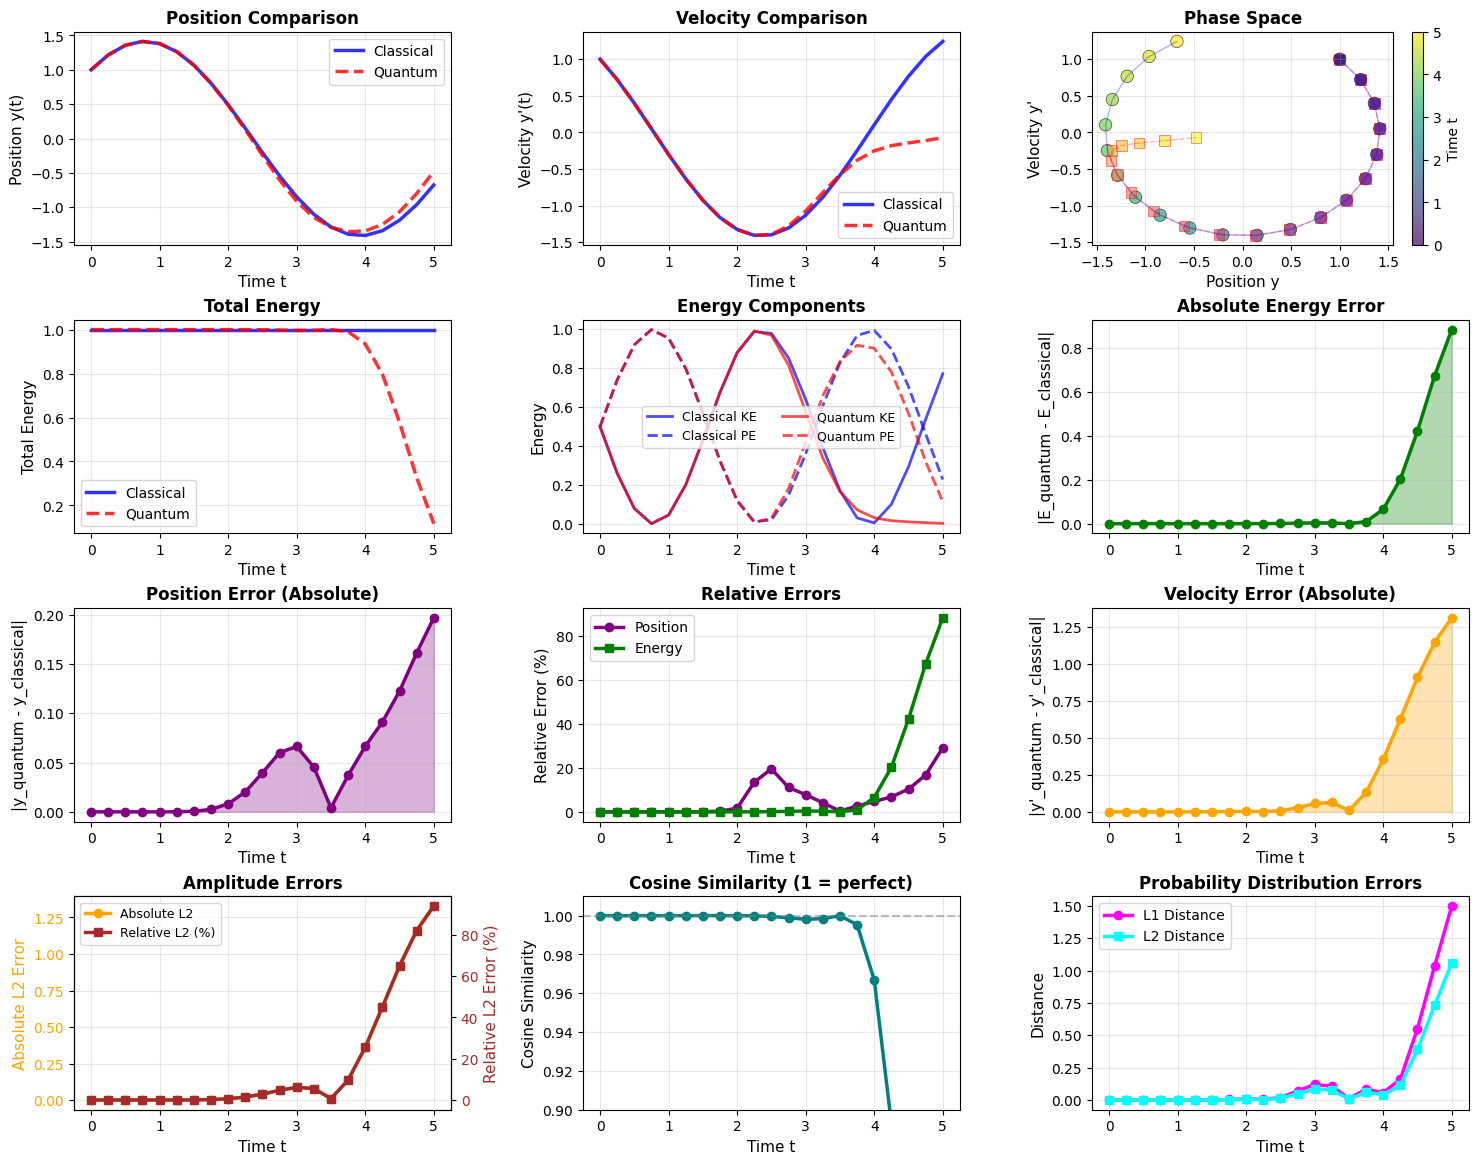

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_all_results(results):
    # Extract data
    t_vals = np.array([r['t'] for r in results])
    
    # Positions and velocities
    y_classical = np.array([r['energies']['classical']['y'] for r in results])
    y_quantum = np.array([r['energies']['quantum']['y'] for r in results])
    yp_classical = np.array([r['energies']['classical']['y_prime'] for r in results])
    yp_quantum = np.array([r['energies']['quantum']['y_prime'] for r in results])
    
    # Energies
    KE_c = np.array([r['energies']['classical']['KE'] for r in results])
    KE_q = np.array([r['energies']['quantum']['KE'] for r in results])
    PE_c = np.array([r['energies']['classical']['PE'] for r in results])
    PE_q = np.array([r['energies']['quantum']['PE'] for r in results])
    E_c = np.array([r['energies']['classical']['total'] for r in results])
    E_q = np.array([r['energies']['quantum']['total'] for r in results])
    
    # Error metrics
    amp_abs_L2 = np.array([r['fit']['amplitude_abs_L2'] for r in results])
    amp_rel_L2 = np.array([r['fit']['amplitude_rel_L2'] for r in results])
    cos_sim = np.array([r['fit']['cosine_similarity'] for r in results])
    prob_L1 = np.array([r['probability_metrics']['L1'] for r in results])
    prob_L2 = np.array([r['probability_metrics']['L2'] for r in results])
    
    # Computed errors
    pos_error = np.abs(y_quantum - y_classical)
    pos_rel_error = pos_error / (np.abs(y_classical) + 1e-10) * 100
    vel_error = np.abs(yp_quantum - yp_classical)
    energy_error = np.abs(E_q - E_c)
    energy_rel_error = energy_error / (np.abs(E_c) + 1e-10) * 100
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(18, 14))
    gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.35)
    
    # Row 1: State variables
    # Position
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t_vals, y_classical, 'b-', linewidth=2.5, label='Classical', alpha=0.8)
    ax1.plot(t_vals, y_quantum, 'r--', linewidth=2.5, label='Quantum', alpha=0.8)
    ax1.set_xlabel('Time t', fontsize=11)
    ax1.set_ylabel('Position y(t)', fontsize=11)
    ax1.set_title('Position Comparison', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Velocity
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t_vals, yp_classical, 'b-', linewidth=2.5, label='Classical', alpha=0.8)
    ax2.plot(t_vals, yp_quantum, 'r--', linewidth=2.5, label='Quantum', alpha=0.8)
    ax2.set_xlabel('Time t', fontsize=11)
    ax2.set_ylabel("Velocity y'(t)", fontsize=11)
    ax2.set_title('Velocity Comparison', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Phase space
    ax3 = fig.add_subplot(gs[0, 2])
    scatter = ax3.scatter(y_classical, yp_classical, c=t_vals, cmap='viridis', 
                         s=80, alpha=0.7, edgecolors='black', linewidth=0.5, label='Classical')
    ax3.plot(y_classical, yp_classical, 'b-', alpha=0.3, linewidth=1)
    ax3.scatter(y_quantum, yp_quantum, c=t_vals, cmap='plasma', 
               s=60, alpha=0.6, marker='s', edgecolors='red', linewidth=0.5, label='Quantum')
    ax3.plot(y_quantum, yp_quantum, 'r--', alpha=0.3, linewidth=1)
    ax3.set_xlabel('Position y', fontsize=11)
    ax3.set_ylabel("Velocity y'", fontsize=11)
    ax3.set_title('Phase Space', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Time t', fontsize=10)
    
    # Row 2: Energies
    # Total energy
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(t_vals, E_c, 'b-', linewidth=2.5, label='Classical', alpha=0.8)
    ax4.plot(t_vals, E_q, 'r--', linewidth=2.5, label='Quantum', alpha=0.8)
    ax4.set_xlabel('Time t', fontsize=11)
    ax4.set_ylabel('Total Energy', fontsize=11)
    ax4.set_title('Total Energy', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # KE and PE
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(t_vals, KE_c, 'b-', linewidth=2, label='Classical KE', alpha=0.7)
    ax5.plot(t_vals, PE_c, 'b--', linewidth=2, label='Classical PE', alpha=0.7)
    ax5.plot(t_vals, KE_q, 'r-', linewidth=2, label='Quantum KE', alpha=0.7)
    ax5.plot(t_vals, PE_q, 'r--', linewidth=2, label='Quantum PE', alpha=0.7)
    ax5.set_xlabel('Time t', fontsize=11)
    ax5.set_ylabel('Energy', fontsize=11)
    ax5.set_title('Energy Components', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=9, ncol=2)
    ax5.grid(True, alpha=0.3)
    
    # Energy error
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(t_vals, energy_error, 'green', linewidth=2.5, marker='o')
    ax6.fill_between(t_vals, 0, energy_error, alpha=0.3, color='green')
    ax6.set_xlabel('Time t', fontsize=11)
    ax6.set_ylabel('|E_quantum - E_classical|', fontsize=11)
    ax6.set_title('Absolute Energy Error', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Row 3: Primary errors
    # Position error
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.plot(t_vals, pos_error, 'purple', linewidth=2.5, marker='o')
    ax7.fill_between(t_vals, 0, pos_error, alpha=0.3, color='purple')
    ax7.set_xlabel('Time t', fontsize=11)
    ax7.set_ylabel('|y_quantum - y_classical|', fontsize=11)
    ax7.set_title('Position Error (Absolute)', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    
    # Relative errors
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.plot(t_vals, pos_rel_error, 'purple', linewidth=2.5, marker='o', label='Position')
    ax8.plot(t_vals, energy_rel_error, 'green', linewidth=2.5, marker='s', label='Energy')
    ax8.set_xlabel('Time t', fontsize=11)
    ax8.set_ylabel('Relative Error (%)', fontsize=11)
    ax8.set_title('Relative Errors', fontsize=12, fontweight='bold')
    ax8.legend(fontsize=10)
    ax8.grid(True, alpha=0.3)
    
    # Velocity error
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.plot(t_vals, vel_error, 'orange', linewidth=2.5, marker='o')
    ax9.fill_between(t_vals, 0, vel_error, alpha=0.3, color='orange')
    ax9.set_xlabel('Time t', fontsize=11)
    ax9.set_ylabel("|y'_quantum - y'_classical|", fontsize=11)
    ax9.set_title('Velocity Error (Absolute)', fontsize=12, fontweight='bold')
    ax9.grid(True, alpha=0.3)
    
    # Row 4: Advanced metrics
    # Amplitude errors
    ax10 = fig.add_subplot(gs[3, 0])
    ax10_twin = ax10.twinx()
    line1 = ax10.plot(t_vals, amp_abs_L2, 'orange', linewidth=2.5, marker='o', label='Absolute L2')
    line2 = ax10_twin.plot(t_vals, amp_rel_L2 * 100, 'brown', linewidth=2.5, marker='s', label='Relative L2 (%)')
    ax10.set_xlabel('Time t', fontsize=11)
    ax10.set_ylabel('Absolute L2 Error', fontsize=11, color='orange')
    ax10_twin.set_ylabel('Relative L2 Error (%)', fontsize=11, color='brown')
    ax10.tick_params(axis='y', labelcolor='orange')
    ax10_twin.tick_params(axis='y', labelcolor='brown')
    ax10.set_title('Amplitude Errors', fontsize=12, fontweight='bold')
    ax10.grid(True, alpha=0.3)
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax10.legend(lines, labels, loc='best', fontsize=9)
    
    # Cosine similarity
    ax11 = fig.add_subplot(gs[3, 1])
    ax11.plot(t_vals, cos_sim, 'teal', linewidth=2.5, marker='o')
    ax11.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
    ax11.set_xlabel('Time t', fontsize=11)
    ax11.set_ylabel('Cosine Similarity', fontsize=11)
    ax11.set_title('Cosine Similarity (1 = perfect)', fontsize=12, fontweight='bold')
    ax11.set_ylim([max(0.9, min(cos_sim) - 0.01), 1.01])
    ax11.grid(True, alpha=0.3)
    
    # Probability errors
    ax12 = fig.add_subplot(gs[3, 2])
    ax12.plot(t_vals, prob_L1, 'magenta', linewidth=2.5, marker='o', label='L1 Distance')
    ax12.plot(t_vals, prob_L2, 'cyan', linewidth=2.5, marker='s', label='L2 Distance')
    ax12.set_xlabel('Time t', fontsize=11)
    ax12.set_ylabel('Distance', fontsize=11)
    ax12.set_title('Probability Distribution Errors', fontsize=12, fontweight='bold')
    ax12.legend(fontsize=10)
    ax12.grid(True, alpha=0.3)
    
    return fig

fig = plot_all_results(results)
plt.show()


## 📝 **User Guide**

**Purpose**  
Provide a simple example demonstrating how to use the quantum LDE solver with custom parameters, including circuit construction, execution, and result analysis.

**Steps**  
1. Set problem parameters: $\omega = 1.0$, $t = 0.0$, $k = 15$ (Taylor series order).  
2. Define the `main` quantum function with register allocation.  
3. Create quantum model and configure backend (state vector simulator).  
4. Synthesise and execute the circuit with 10,000 shots.  
5. Compare results against classical solution.

In [38]:
params = preprocess_harmonic_oscillator(omega=1.0, t=0.0, k=15)

@qfunc
def main(work: Output[QArray[QBit]], ancilla1: Output[QBit], ancilla2: Output[QArray[QBit]]):
	params = preprocess_harmonic_oscillator(omega=1.0, t=0.0, k=15)
	nf = params['norm_factors']
	allocate(1, ancilla1)
	allocate(4, ancilla2) # log2(k+1) = log2(16) = 4
	allocate(1, work) # log2(N) = log2(2) = 1

	encode(work, ancilla1, ancilla2, params['C'], nf['C_total'], params['D'], nf['D_total'], nf['N'])
	entangle(work, ancilla2, params['k'], params['A'])
	decode(ancilla1, ancilla2, params['C'], nf['C_total'], params['D'], nf['D_total'], nf['N'])

# Creating the quantum model
qmod = create_model(main)

# Defining the backend as the Classiq state vector simulator
state_vector=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR)

# Setting the execution preferences
qmod = set_execution_preferences(qmod, ExecutionPreferences(backend_preferences=state_vector, num_shots=10000))

# Synthesizing the model into a quantum program
qprog= synthesize(qmod)

# Executing the quantum program
job = execute(qprog)

# Retrieving the results as a nested data structure
res = job.get_sample_result()

result = compare_quantum_and_classical(res, params['M'], params['b'], params['x0'], params['t'], verbose=True)

=== Quantum vs Classical Comparison ===
t: 0.000000
Shots success rate: 1.000000
P(work=1 | success) shots: 0.505700
P(work=1 | success) SV:    0.500000
P(work=1) classical:       0.500000
Amplitude L2 error: 3.058403e-14  relative 0.0000%
Cosine similarity:  1.000000
Prob L1: 1.948441e-14, L2: 1.377896e-14
Energy comparison
Quantum,   KE=0.500000, PE=0.500000, Total=1.000000
Classical, KE=0.500000, PE=0.500000, Total=1.000000
Energy gap |E_q - E_c|: 5.551115e-16
